##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# RNN을 사용한 텍스트 분류 


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## 입력 파이프라인 설정


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.
- 이진분류 (긍정/부정) 데이터 셋 

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):
-  (텍스트, 레이블 쌍)의 데이터세트를 반환

In [6]:
for example, label in train_dataset.take(10):
  print('text: ', example.numpy())
  print('label: ', label.numpy())
  print()

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0

text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish.

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

- repeat()    
: 데이터 셋을 반복한다.

- batch()    
: 데이터 배치의 크기를 정한다. (위의 코드에서는 1배치 당 64개의 데이터)

- take()    
: 해당 배치를 몇 번 불러올지 정한다. (배치를 5번 불러온다)

- prefetch     
: 학습중일때, 데이터 로드시간을 줄이기 위해 미리 메모리에 적재시킴     
    - 이때, 괄호안의 숫자는 얼마만큼 적재시킬지에 대한 숫자

- .AUTOTUNE
    - 네트워크가 알아서 지정하도록 설정

In [11]:
for example, label in train_dataset.take(5):
  print('texts: ', example.numpy()[:3])
  print('labels: ', label.numpy()[:3])
  print()

texts:  [b'Yeah, unfortunately I came across the DVD of this and found that it was incredibly awful.<br /><br />First of all, the characters suck. I mean, come on, if some dork in an orange hat who calls himself \'Orange Sherbert\' is the best creative idea these guys could come up for a character, then they should definitely not be in the film-making scene. Poor "costumes", bad "interviews", and basically there is not one "wrestler" on this whole disc with any shred of charisma.<br /><br />The "wrestling" in Splatter Rampage Wrestling is nothing more than these idiots gently and playfully bouncing together on a trampoline. They make sure to giggle together all the while, too, making the experience seem more like a toddler\'s playtime than a "wrestling deathmatch".<br /><br />Basically, Splatter Rampage Wrestling is a pretty lackluster Backyard Wrestling clone. Only, instead of blood, weapons, mayhem, and WRESTLING, we get a trampoline, giggling kids, TERRIBLE audio, and some guy calle

## 텍스트 인코더 만들기
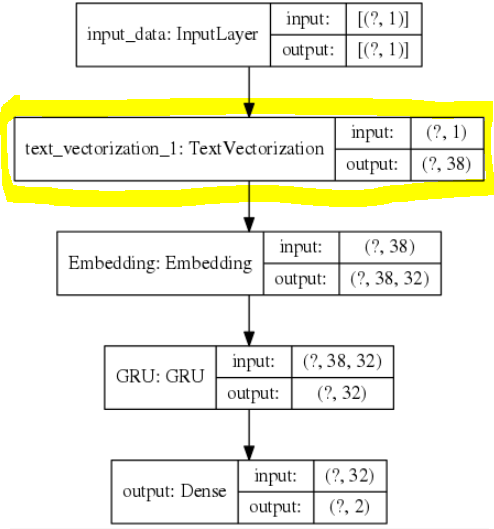

기존에 model에 text를 태우기 위해서는 model에 들어갈 input을 vector화시키는 작업을 진행한 후 태웠다.

예를 들면 "나는 학교에 간다" 라는 문장을 [23,10,5,0,0,0,0,0] 으로 vector화 하여 태웠던 것을 말한다.

tf.keras.layers.experimental.preprocessing.TextVectorization 를 사용하면 간단히 전처리를 할 수 있다. 

- 모델의 graph를 보면 알 수 있듯 모델 자체에 text vectorization이 있어 따로 전처리를 할 필요도 없으며,
모델을 저장하면, 예측할 때 어떤 데이터가 오든 간에 모델을 학습시켰던 데이터에 기반한 tokenizer와 vocab을 따로 불러오지 않고 예측할 수 있다.


The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

#### 텍스트 전처리
tf.keras.layers.TextVectorization: 원시 문자열을 Embedding 레이어 또는 Dense 레이어에서 읽을 수 있는 인코딩 표현으로 바꿉니다.

- adapt() 메서드를 통해 학습 데이터에 노출하여 전처리 레이어의 상태를 설정할 수 있습니다.
- Numpy 배열 또는 tf.data.Dataset 객체를 사용합니다. 
- StringLookup 및 TextVectorization 의 경우, 문자열의 목록을 전달할 수도 있습니다.

In [16]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

- 층의 어휘를 설정한다. 다음은 처음 20개의 토큰입니다. 패딩 및 알 수 없는 토큰 다음에 빈도별로 정렬됩니다.

In [17]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

- 어휘가 설정되면 레이어는 텍스트를 인덱스로 인코딩할 수 있습니다. (당신이 고정 된 설정하지 않는 한 지수의 텐서는 배치에서 가장 긴 순서로 0 채워집니다 output_sequence_length ) :

In [18]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 25,   1,   5, ...,   0,   0,   0],
       [ 10, 855,   4, ...,   0,   0,   0],
       [ 10, 434,  11, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [19]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"His choice of films, the basic 'conceit' of the production (which places him in the sets or simulacra of the films he is commenting on ) and his delivery are brilliant! But if you want Freud, be aware that you're getting Zizek's version of Lacan, which should not be confused with Lacan himself. As usual, Zizek delivers complex ideas with gusto and in a convincing manner. The rub is he is also quite mercurial and so there may be more in his gusto than in actual content. Cinematically, it is a gem. Psychologically, this will have people of all persuasions (Freudians, Lacanians and Jungians) scratching their heads but reaching for the popcorn all the same. Zizek is a phenomenon and pop icon unto himself."
Round-trip:  his [UNK] of films the [UNK] [UNK] of the production which [UNK] him in the sets or [UNK] of the films he is [UNK] on and his [UNK] are brilliant but if you want [UNK] be [UNK] that youre getting [UNK] version of [UNK] which should not be [UNK] with [UNK] himsel

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. 모델은 `tf.keras.Sequential`을 통해 빌드업

2. 첫번째 레이어로 `encoder`가 들어간다. 
- 토큰 인덱스의 시퀀스에 텍스트를 변환한다. 

3. 그 다음 레이어로는 인코더 후 임베딩된 레이어가 온다. 
 - embedding layer : 단어 당 하나의 벡터 
   - 호출 시 단어 인덱스 시퀀스를 벡터 시퀀스로 변환
 - 충분한 데이터에 대해 훈련된 유사한 의미를 가진 단어들은 종종 유사한 벡터를 가지게 된다. 
 
- This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. 순환 신경망(RNN)은 요소를 반복하여 시퀀스 입력을 처리 
-  RNN은 한 타임 스텝의 출력을 다음 타임 스텝의 입력으로 전달
    - tf.keras.layers.Bidirectional 래퍼는 또한 RNN 층으로 사용될 수있다. 이것은 RNN 레이어를 통해 입력을 앞뒤로 전파한 다음 최종 출력을 연결합니다.

        - 양방향 RNN의 주요 이점       
    입력 시작 부분의 신호가 출력에 영향을 미치기 위해 모든 시간 단계를 통해 처리될 필요가 없다는 것입니다.

        - 양방향 RNN의 주요 단점     
     단어가 끝에 추가될 때 예측을 효율적으로 스트리밍할 수 없다는 것입니다.

5. RNN 단일 벡터에 순서를 전환 한 후에 두 layers.Dense 분류 출력으로 단일 로짓이 벡터 표현에서 일부 최종 처리 및 변환한다.


The code to implement this is below:

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # LSTM 네트워크를 양방향으로 구성 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

모델의 모든 레이어가 단일 입력만 갖고 단일 출력을 생성하기 때문에 여기에서 Keras 순차 모델이 사용된다는 점

Stateful RNN 레이어를 사용하려는 경우 RNN 레이어 상태를 검색하고 재사용할 수 있도록 Keras 기능 API 또는 모델 서브클래싱으로 모델을 빌드

#### Bidirectional RNNsPermalink
- 시계열 순서열에 대해서(e.g. text), RNN model은 앞에서부터 뒤로 처리하는 것 뿐만 아니라, 반대 방향으로도 같이 처리를 한다면 더 성능이 좋아진다. 예를 들어, 문장에서 다음 단어를 예측하는데 있어서, 이전에 오는 단어만 보는 것이 아닌 단어 주변의 문맥을 사용하는 것이 더 효과적일 수도 있다.

    - Keras는 이러한 양방향 RNN을 구현할 수 있도록 쉬운 API를 제공한다: tf.keras.layers.Bidirectional

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

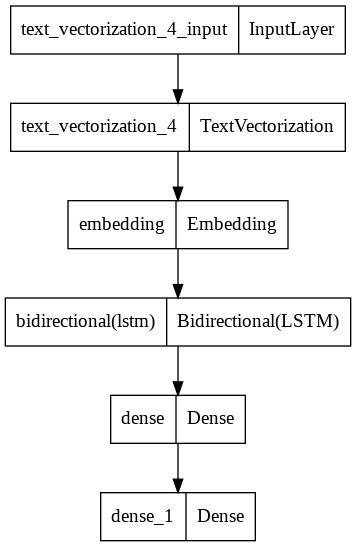

In [24]:
from keras.utils import plot_model
plot_model(model)

In [25]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


이것이 예상대로 작동하는지 확인하려면 문장을 2번 평가해준다.    
1) 첫 번째,  패딩이 없도록 지정하여 단독 평가   
2) 두 번째, 더 긴 문장으로 배치에서 다시 평가    
-> 두 결과가 동일해야한다.    
     


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[-0.01792091]


In [27]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 136ms/step
[-0.0179209]


In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [29]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 41s 86ms/step - loss: 0.6411 - accuracy: 0.5617 - val_loss: 0.5133 - val_accuracy: 0.7255
Epoch 2/10
391/391 [==============================] - 32s 82ms/step - loss: 0.4604 - accuracy: 0.7711 - val_loss: 0.4982 - val_accuracy: 0.7385
Epoch 3/10
391/391 [==============================] - 36s 90ms/step - loss: 0.4007 - accuracy: 0.8192 - val_loss: 0.3730 - val_accuracy: 0.8443
Epoch 4/10
391/391 [==============================] - 33s 83ms/step - loss: 0.3512 - accuracy: 0.8464 - val_loss: 0.3459 - val_accuracy: 0.8510
Epoch 5/10
391/391 [==============================] - 42s 107ms/step - loss: 0.3307 - accuracy: 0.8562 - val_loss: 0.3345 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 33s 83ms/step - loss: 0.3184 - accuracy: 0.8636 - val_loss: 0.3334 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3133 - accuracy: 0.8669 - val_loss: 0.3238 - val_accuracy

In [30]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 48ms/step - loss: 0.3156 - accuracy: 0.8574
Test Loss: 0.3155549466609955
Test Accuracy: 0.8574399948120117


(0.0, 0.6580788791179657)

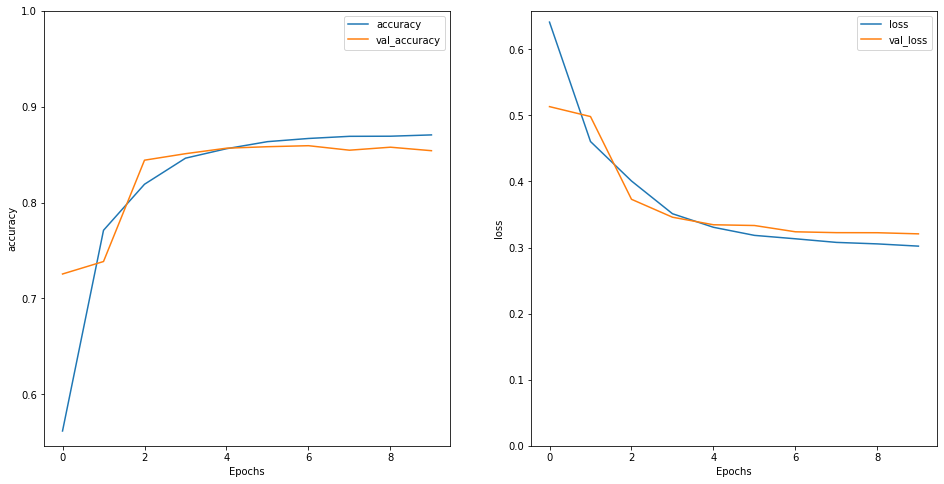

In [31]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [32]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [33]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                      

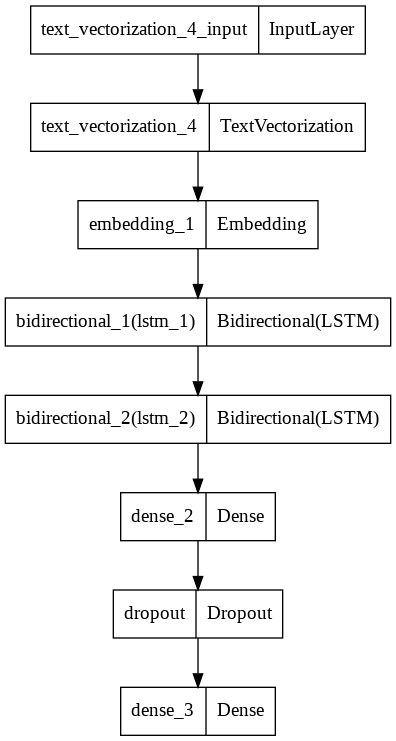

In [35]:
plot_model(model)

In [36]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [37]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 73s 153ms/step - loss: 0.6133 - accuracy: 0.6102 - val_loss: 0.4291 - val_accuracy: 0.8115
Epoch 2/10
391/391 [==============================] - 56s 142ms/step - loss: 0.3809 - accuracy: 0.8342 - val_loss: 0.3628 - val_accuracy: 0.8250
Epoch 3/10
391/391 [==============================] - 56s 142ms/step - loss: 0.3355 - accuracy: 0.8555 - val_loss: 0.3446 - val_accuracy: 0.8510
Epoch 4/10
391/391 [==============================] - 56s 144ms/step - loss: 0.3161 - accuracy: 0.8652 - val_loss: 0.3276 - val_accuracy: 0.8464
Epoch 5/10
391/391 [==============================] - 56s 143ms/step - loss: 0.3122 - accuracy: 0.8666 - val_loss: 0.3253 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 55s 141ms/step - loss: 0.3038 - accuracy: 0.8704 - val_loss: 0.3286 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 55s 141ms/step - loss: 0.3016 - accuracy: 0.8706 - val_loss: 0.3209 - val_ac

In [38]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 30s 77ms/step - loss: 0.3267 - accuracy: 0.8635
Test Loss: 0.3267231285572052
Test Accuracy: 0.8635200262069702


In [39]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 4s 4s/step
[[-1.7434831]]


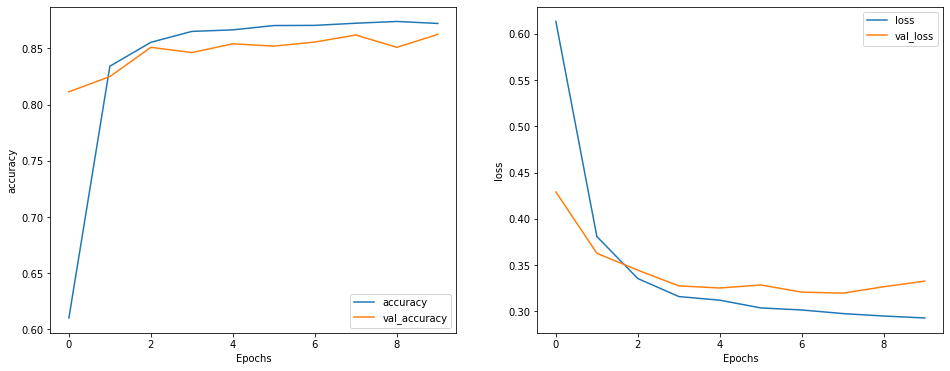

In [41]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).


In [77]:
def sentiment_predict(new_sentence):
    scores = model.predict(np.array(new_sentence)) # 예측
    for score in scores:
        if(score > 0):
            print(f"{(float(score * 100)):.2f}% 확률로 긍정 리뷰입니다.\n")
        else:
            print(f"{float((abs(score))) * 100:.2f}% 확률로 부정 리뷰입니다.\n")

In [81]:
examples = [
  "The movie was great!",
  "The movie was soso.",
  "The movie was terrible...",
  "The movie was good"
]


sentiment_predict(examples)

1/1 [==============================] - 0s 21ms/step
32.26% 확률로 긍정 리뷰입니다.

7.83% 확률로 부정 리뷰입니다.

55.78% 확률로 부정 리뷰입니다.

7.51% 확률로 긍정 리뷰입니다.



In [83]:
sample_text = ['The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.']
sentiment_predict(sample_text)

1/1 [==============================] - 0s 24ms/step
23.33% 확률로 긍정 리뷰입니다.

